## Import data_utils

In [1]:
from climsim_utils.data_utils import *

2023-08-21 14:36:29.941637: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 14:36:30.922437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Instantiate class

In [2]:
grid_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/grid_info/ClimSim_low-res_grid-info.nc'
norm_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/normalizations/'

grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset(norm_path + 'inputs/input_mean.nc')
input_max = xr.open_dataset(norm_path + 'inputs/input_max.nc')
input_min = xr.open_dataset(norm_path + 'inputs/input_min.nc')
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale.nc')

data = data_utils(grid_info = grid_info, 
                  input_mean = input_mean, 
                  input_max = input_max, 
                  input_min = input_min, 
                  output_scale = output_scale)

## Load data and set pressure grid

In [3]:
# paths to scoring data
input_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_input.npy'
target_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_target.npy'

# paths to model predictions
cvae_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/cVAE/cvae_preds_manual.h5'
hsr_pred_path = '/ocean/projects/atm200007p/shared/neurips_proj/final_metrics/predictions/HSR/hsr_preds_bestcrps.h5'
rpn_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/rpn_pred_v1_stride6.npy'
cnn_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/val_predict_cnn_reshaped_stride6_FINAL.npy'
mlp_pred_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/figure_ingredients/001_backup_phase-7_retrained_models_step2_lot-147_trial_0027.best.h5.npy'

# set variables to V1 subset
data.set_to_v1_vars()

# path to target input
data.input_scoring = np.load(input_path)

# path to target output
data.target_scoring = np.load(target_path)

# set pressure weights
data.set_pressure_grid(input_arr = data.input_scoring)

# load model predictions
data.model_names = ['CNN','cVAE','HSR','MLP', 'RPN']
preds = [data.load_npy_file(load_path = cnn_pred_path), 
         data.load_h5_file(load_path = cvae_pred_path), 
         data.load_h5_file(load_path = hsr_pred_path), 
         data.load_npy_file(load_path = mlp_pred_path), 
         data.load_npy_file(load_path = rpn_pred_path)]
data.preds_scoring = dict(zip(data.model_names, preds))

## Weight outputs

1. Undo output scaling

2.  Weight vertical levels by dp/g

3. Weight horizontal area of each grid cell by a[x]/mean(a[x])

4. Convert units to a common energy unit

In [4]:
data.reweight_target(data_split = 'scoring')
data.reweight_preds(data_split = 'scoring')

data.metrics_names = ['MAE', 'RMSE', 'R2']
data.create_metrics_df(data_split = 'scoring')

/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:649: RuntimeWarning: divide by zero encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:649: RuntimeWarning: invalid value encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:649: RuntimeWarning: divide by zero encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:649: RuntimeWarning: divide by zero encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:649: RuntimeWarning: divide by zero en

## Create plots

In [5]:
%config InlineBackend.figure_format = 'retina'
letters = string.ascii_lowercase

In [12]:
dict_idx = data.metrics_var_scoring
dict_var = data.metrics_idx_scoring

plot_df_byvar = {}
for metric in data.metrics_names:
    plot_df_byvar[metric] = pd.DataFrame([dict_idx[model][metric] for model in data.model_names],
                                               index=data.model_names)
    plot_df_byvar[metric] = plot_df_byvar[metric].rename(columns = data.var_short_names).transpose()

In [13]:
plot_df_byvar['MAE']

,CNN,cVAE,HSR,MLP,RPN
variable,,,,,
$dT/dt$,2.585418,2.732051,2.844789,2.682765,2.685253
$d1/dt$,4.400639,4.679666,4.784426,4.494752,4.592410
NETSW,18.845029,19.729191,19.816967,13.360914,18.878685
FLWDS,8.597703,6.588051,6.266635,5.224468,6.017693
PRECSC,3.364180,3.321645,3.511187,2.683915,3.328444
PRECC,37.825799,38.805963,42.379195,34.333065,37.455143
SOLS,10.830984,10.939536,11.314418,7.970805,10.355971
SOLL,13.152971,13.461330,13.602788,10.299178,12.955313
SOLSD,5.816831,6.158717,6.330680,4.533141,5.845594


### Plot 1

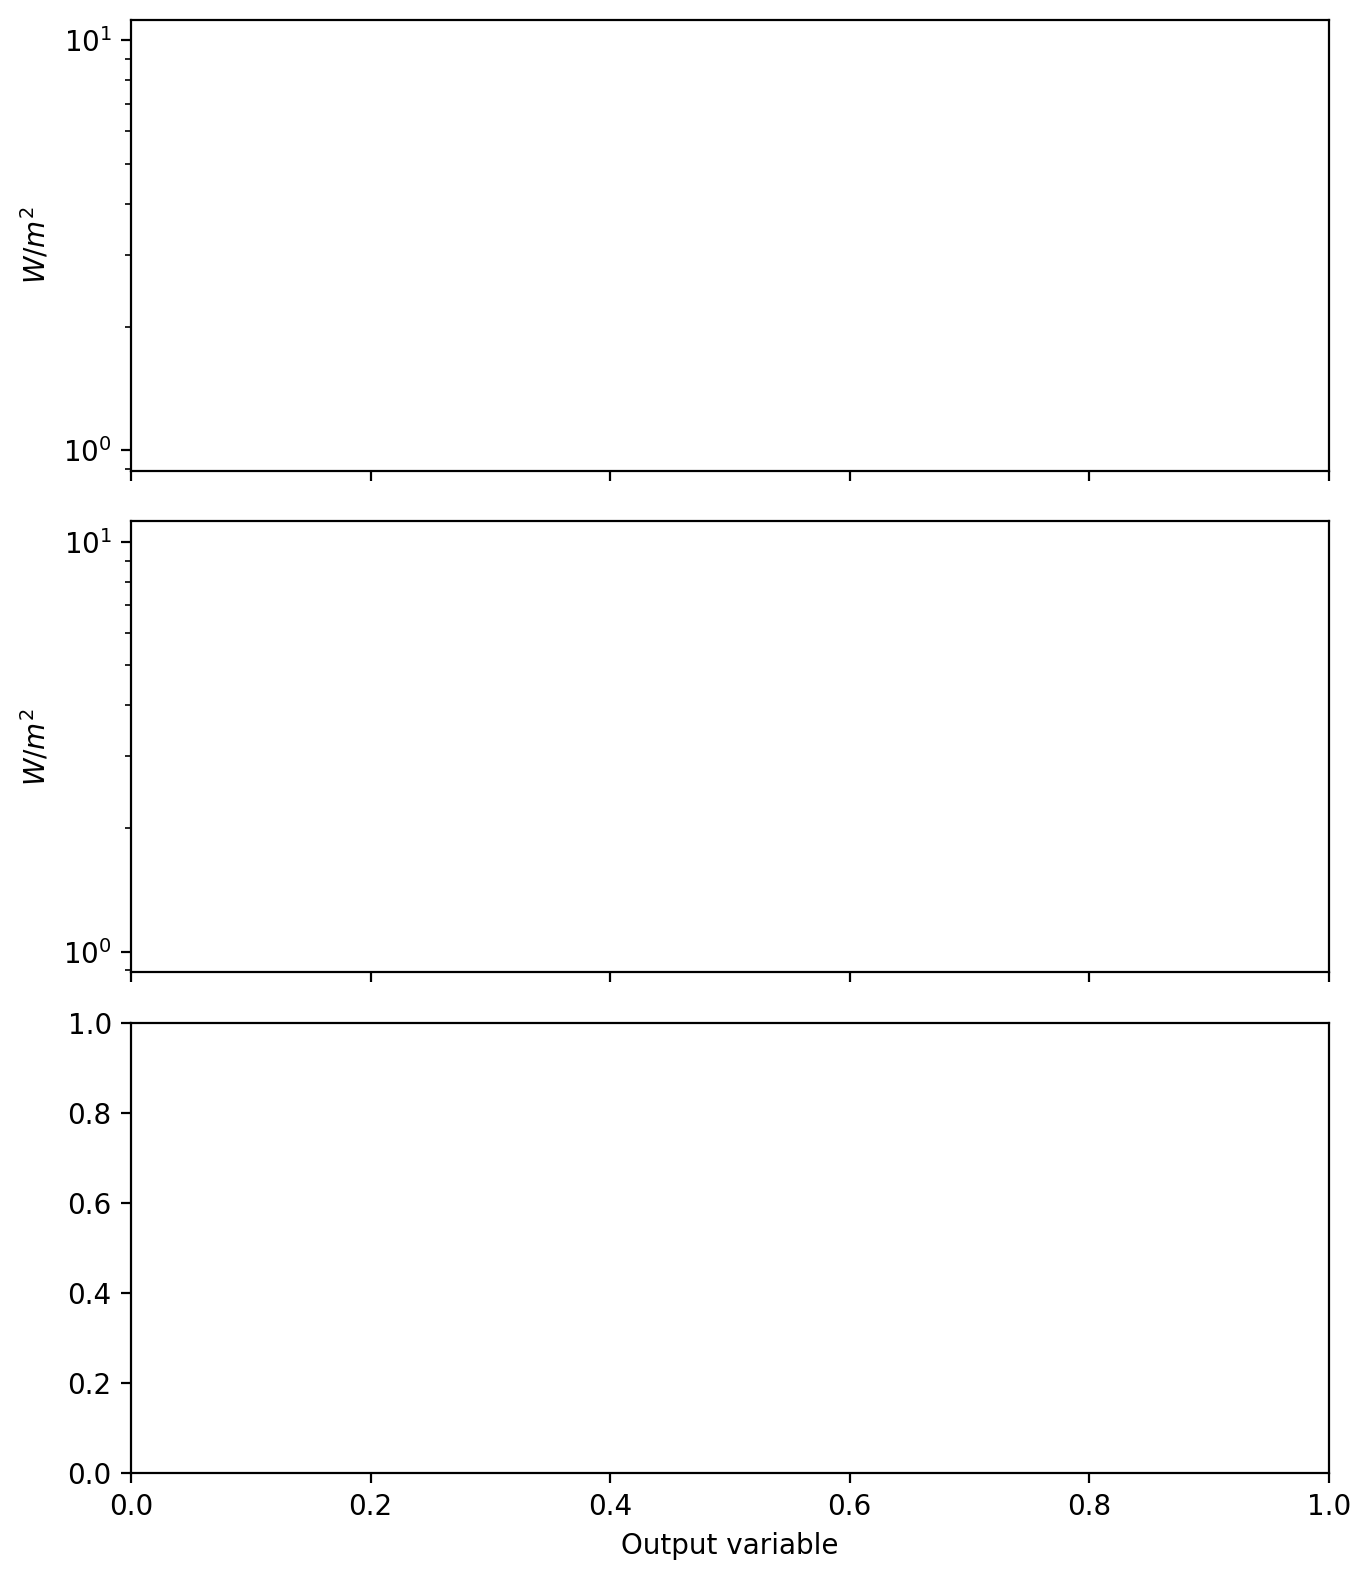

In [15]:
fig, axes = plt.subplots(nrows  = len(data.metrics_names), sharex = True)
for i in range(len(data.metrics_names)):
    if data.metrics_names[i] != 'R2':
        axes[i].set_ylabel('$W/m^2$')
        axes[i].set_yscale('log')
    else:
        axes[i].set_ylim(0,1)
    pass
axes[i].set_xlabel('Output variable')

fig.set_size_inches(7,8)
fig.tight_layout()

### Plot 2

### Plot 3

### Plot 4